Importing Libraries and Dependencies

In [1]:
# Importing necessary packages
import tempfile
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scripts.balanced_generator import BalanceCovidDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import os

Initialising model arguments and constants

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=480, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--folds', default=2, type=int, help='Number of folds for cross validation')
parser.add_argument('--num_classes', default=3, type=int, help='Number of classes in the dataset')
parser.add_argument('--num_channels', default=3, type=int, help='Number of channels per image')
parser.add_argument('--epochs', default=10, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument('--seed', default=14, type=int, help='Seed to generate random data')
parser.add_argument("-p", "--plot", type=str, default="plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="model_plot.png", help="Path to save model's plot")
parser.add_argument("--model_dir", type=str, default="saved_models/", help="Path to save model")
parser.add_argument("--model_name", type=str, default="ResNet152V2", help="Name of the model")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr

Data exploration

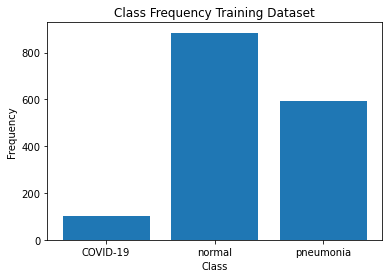

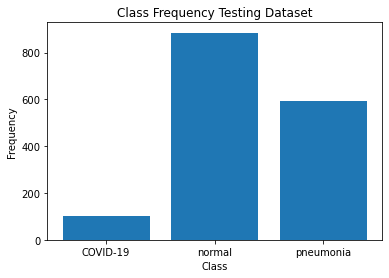

In [3]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0, index_col=None)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0, index_col=None)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

# Plotting distribution of classes in training dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# Plotting distribution of classes in testing dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Testing Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

Creating the model

In [4]:
# Method to add regularisation
'''def add_regularization(mdl, regularizer=regularizers.l2(0.0001)):

    if not isinstance(regularizer, regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return mdl

    for layer in mdl.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = mdl.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    mdl.save_weights(tmp_weights_path)

    # Load the model from the config
    mdl = model_from_json(model_json)

    # Reload the model weights
    mdl.load_weights(tmp_weights_path, by_name=True)
    return mdl'''

# Loading ResNet152V2 model trained on imagenet without head
baseModel = ResNet152V2(
    weights="imagenet", include_top=False,
    input_tensor=Input(shape=(args.input_size, args.input_size,
                              args.n_channels))
)

# Constructing the head for classification (to be trained)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# Fixing the weights of base model
baseModel.trainable = False

#  Adding regularisation
model = Model(inputs=baseModel.input, outputs=headModel)
#model = add_regularization(model)

# Saving a plot of the model
#plot_model(model, to_file=args.model_plot, show_shapes=True, show_layer_names=True)

Instantiating data generators to load datasets

In [5]:
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=df_test,
    directory=os.path.join(args.data_dir, args.test_data_dir),
    target_size=(args.input_size, args.input_size),
    color_mode="rgb",
    x_col="file_name",
    y_col="class",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    validate_filenames=False
)

def get_model(df_trn, df_val):
    map = {
            'normal': 0,
            'pneumonia': 1,
            'COVID-19': 2
            }
    trn_generator = BalanceCovidDataset(
        data_dir=os.path.join(args.data_dir),
        data_files=df_trn.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping = map
    )

    val_generator = BalanceCovidDataset(
        data_files=df_trn.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        data_dir=os.path.join(args.data_dir),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping = map
    )

    return model, trn_generator, val_generator

Found 1579 non-validated image filenames belonging to 3 classes.


Training the model

[INFO] Fold 1/2
6714 248
6714 248
[INFO] Training model


/homes/as405/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['normal', 'pneumonia', 'COVID-19'], y=['pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'CO

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 105 steps, validate for 105 steps
Epoch 1/10
105/105 [==============================] - 271s 3s/step - loss: 0.8756 - accuracy: 0.6286 - val_loss: 0.9703 - val_accuracy: 0.6060
Epoch 2/10
105/105 [==============================] - 233s 2s/step - loss: 0.7014 - accuracy: 0.7214 - val_loss: 1.0580 - val_accuracy: 0.6357
Epoch 3/10
105/105 [==============================] - 224s 2s/step - loss: 0.5841 - accuracy: 0.7476 - val_loss: 1.1759 - val_accuracy: 0.6179
Epoch 4/10
105/105 [==============================] - 229s 2s/step - loss: 0.5489 - accuracy: 0.7893 - val_loss: 1.1059 - val_accuracy: 0.6095
Epoch 5/10
105/105 [==============================] - 228s 2s/step - loss: 0.5254 - accuracy: 0.7988 - val_loss: 1.2214 - val_accuracy: 0.5869
Epoch 6/10
105/105 [==============================] - 228s 2s/step - loss: 0.4975 - accuracy: 0.8155 - val_loss: 1.3696 - val_accuracy: 0.6298
Epoch 7/10
105/105 [============================

/homes/as405/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['normal', 'pneumonia', 'COVID-19'], y=['pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'pneumonia', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19',

[INFO] Training model
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 105 steps, validate for 105 steps
Epoch 1/10
105/105 [==============================] - 227s 2s/step - loss: 0.5768 - accuracy: 0.7952 - val_loss: 1.5988 - val_accuracy: 0.5381
Epoch 2/10
105/105 [==============================] - 230s 2s/step - loss: 0.4685 - accuracy: 0.8238 - val_loss: 1.1954 - val_accuracy: 0.6274
Epoch 3/10
105/105 [==============================] - 225s 2s/step - loss: 0.4870 - accuracy: 0.8107 - val_loss: 1.3434 - val_accuracy: 0.5857
Epoch 4/10
105/105 [==============================] - 223s 2s/step - loss: 0.4560 - accuracy: 0.8417 - val_loss: 1.3310 - val_accuracy: 0.6512
Epoch 5/10
105/105 [==============================] - 216s 2s/step - loss: 0.4334 - accuracy: 0.8476 - val_loss: 1.4687 - val_accuracy: 0.5845
Epoch 6/10
105/105 [==============================] - 213s 2s/step - loss: 0.5002 - accuracy: 0.8131 - val_loss: 1.5090 - val_accuracy: 0.5286
Epoch 7/10
105/105 [======

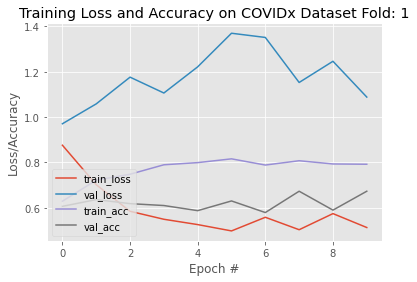

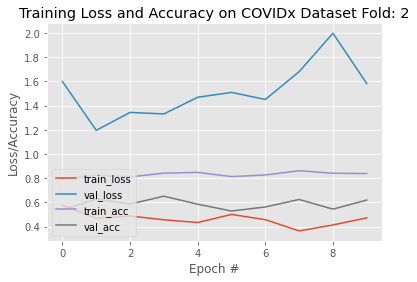

In [6]:
mapping = {'normal': 0,
       'pneumonia': 1,
       'COVID-19': 2}

fold_no = 1

# generating folds to train
skf = StratifiedKFold(n_splits=args.folds, shuffle=True, random_state=args.seed)

# enumerate the splits and summarize the distributions
for train_idx, val_idx in skf.split(df_train, train_labels):
    print("[INFO] Fold {}/{}".format(fold_no,args.folds))
    # select rows
    training_data = df_train.iloc[train_idx]
    validation_data = df_train.iloc[val_idx]

    # Getting model and generators fitted on ith fold data
    model, train_generator, validation_generator = get_model(training_data, validation_data)

    # Compiling the model
    opt = Adam(learning_rate=LR)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
    # Calculating class weights since COVID-19 data is very less
    class_weights = class_weight.compute_class_weight('balanced',
                                                      ['normal', 'pneumonia', 'COVID-19'], # Getting class idx
                                                      train_generator.classes)

    # Formatting class weights for keras
    cw = {mapping['normal']: class_weights[0],
         mapping['pneumonia']: class_weights[1],
         mapping['COVID-19']: class_weights[2]}

    # CREATE CALLBACKS
    '''checkpoint = ModelCheckpoint(args.model_dir+args.model_name+".h5",
                            monitor='val_accuracy', verbose=1,
                            save_best_only=True, mode='max')
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
    
    callbacks_list = [checkpoint, es]'''

    # Training model
    print("[INFO] Training model")
    H = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator) // BS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator) // BS,
        epochs=EPOCHS,
        class_weights=[1., 1., 6.])
    ''',
        callbacks=callbacks_list)'''

    # Plotting training loss and accuracy
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on COVIDx Dataset Fold: {}".format(fold_no) )
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(str(fold_no)+args.plot)

    fold_no = fold_no + 1

    clear_session()

Evaluating the model and generating predictions

In [7]:
# Predicting on testing data
print("[INFO] Predicting on testing data")
test_file_names = test_generator.filenames
nb_samples = len(test_file_names)
test_generator.reset()

# Loading best model
#model.load_weights(args.model_dir+args.model_name+".h5")
pred = model.predict_generator(test_generator, steps=nb_samples, verbose=1)
pred = np.argmax(pred, axis=1)

# Getting class label map
label_map = test_generator.class_indices
for c in classes:
    label_map.update({label_map.get(c):c})
    label_map.pop(label_map.get(label_map.get(c)))
temp = []
for i in range(len(label_map)):
    temp.append(label_map.get(i))
label_map = temp
del temp

# Printing classification report
print(classification_report(test_generator.classes, pred, target_names=label_map))

[INFO] Predicting on testing data
Instructions for updating:
Please use Model.predict, which supports generators.
1579/1579 [==============================] - 183s 116ms/step
              precision    recall  f1-score   support

    COVID-19       0.05      0.56      0.09       100
      normal       0.07      0.04      0.05       885
   pneumonia       0.50      0.00      0.00       594

    accuracy                           0.06      1579
   macro avg       0.21      0.20      0.05      1579
weighted avg       0.23      0.06      0.03      1579



Printing confusion matrix

In [8]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(test_generator.classes, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

[[ 56  43   1]
 [852  33   0]
 [217 376   1]]
Overall Accuracy: 0.0570
COVID Sensitivity: 0.5600
COVID Specificity: 0.2772


Plotting the training performance

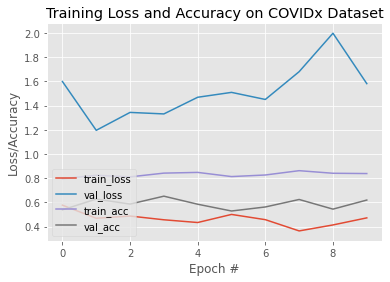

In [9]:
# Plotting training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args.plot)